# XRAY - VGG - RANDOM 

## Installing and Importing Libraries

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG

import tensorflow as tf
from pathlib import Path

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3500)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

import keract
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

from sklearn.utils import class_weight 

1 Physical GPUs, 1 Logical GPUs


## Importing Dataset and Data Pre-Processing

In [2]:
data_dir = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/XRAY/XRAY_RANDOM/"
train_data_dir= '/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/XRAY/XRAY_RANDOM/train/'
test_data_dir= '/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/XRAY/XRAY_RANDOM/test/'
img_width, img_height = 224, 224 
channels = 3
batch_size = 32
# image_arr_size= img_width * img_height * channels

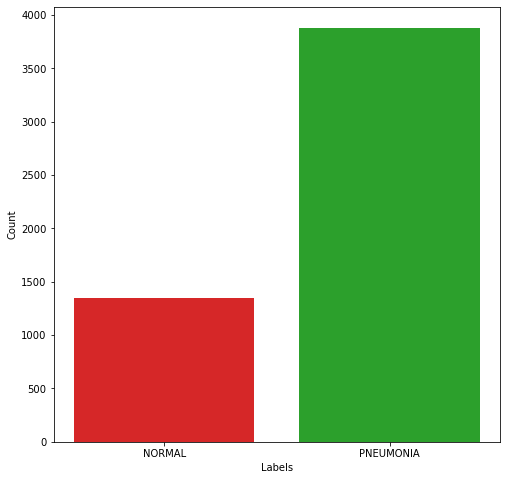

In [3]:
cnv_images = len(glob(train_data_dir + 'NORMAL/*.jpeg'))
dme_images = len(glob(train_data_dir + 'PNEUMONIA/*.jpeg'))
data= {'NORMAL': cnv_images, 'PNEUMONIA': dme_images}
labels = list(data.keys()) 
count = list(data.values()) 

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(labels, count, color=['tab:red', 'tab:green'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show() 

### Sample Images from the Dataset

Normal


/home/maia/anaconda3/envs/MST_TRAIN/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  # Remove the CWD from sys.path while we load stuff.


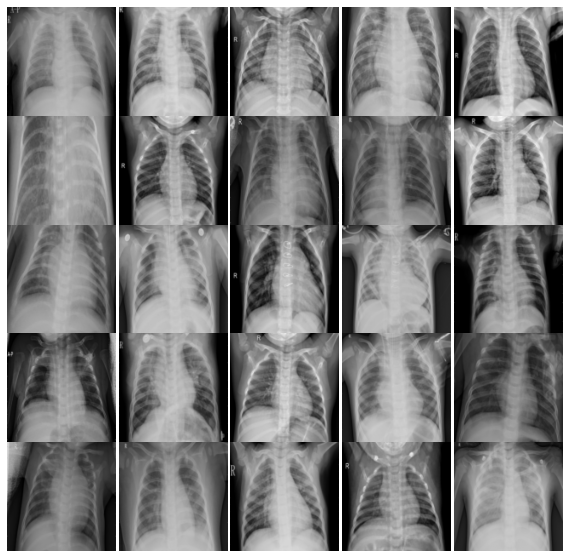

In [4]:
print("Normal")
multipleImages = glob(data_dir + 'train/NORMAL/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('normal_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Pneumonia


/home/maia/anaconda3/envs/MST_TRAIN/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  # Remove the CWD from sys.path while we load stuff.


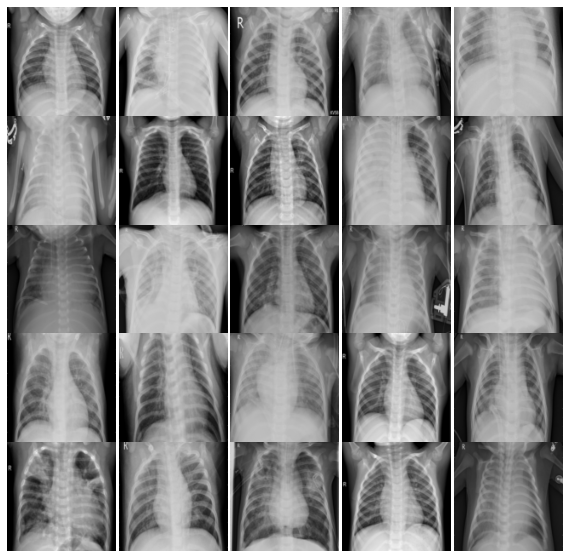

In [5]:
print("Pneumonia")
multipleImages = glob(data_dir + 'train/PNEUMONIA/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('cnv_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

### Keras Data Generators

In [6]:
train_datagen = ImageDataGenerator(
)

valid_test_datagen = ImageDataGenerator(
)

In [7]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    batch_size= batch_size,  
    class_mode= 'categorical'
) 

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    batch_size= batch_size,  
    class_mode= 'categorical'
)

Found 5231 images belonging to 2 classes.
Found 469 images belonging to 2 classes.


In [8]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

nb_train_samples = len(train_generator.filenames)  
nb_test_samples = len(test_generator.filenames)

# Model
* VGG16 CNN architecture is used for calssification.
* Pretrained on the 'ImageNet' dataset.

In [9]:
model = VGG16(include_top= True, input_shape= (img_width, img_height, channels), classes=2, weights=None)
model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### VGG16 Architecture

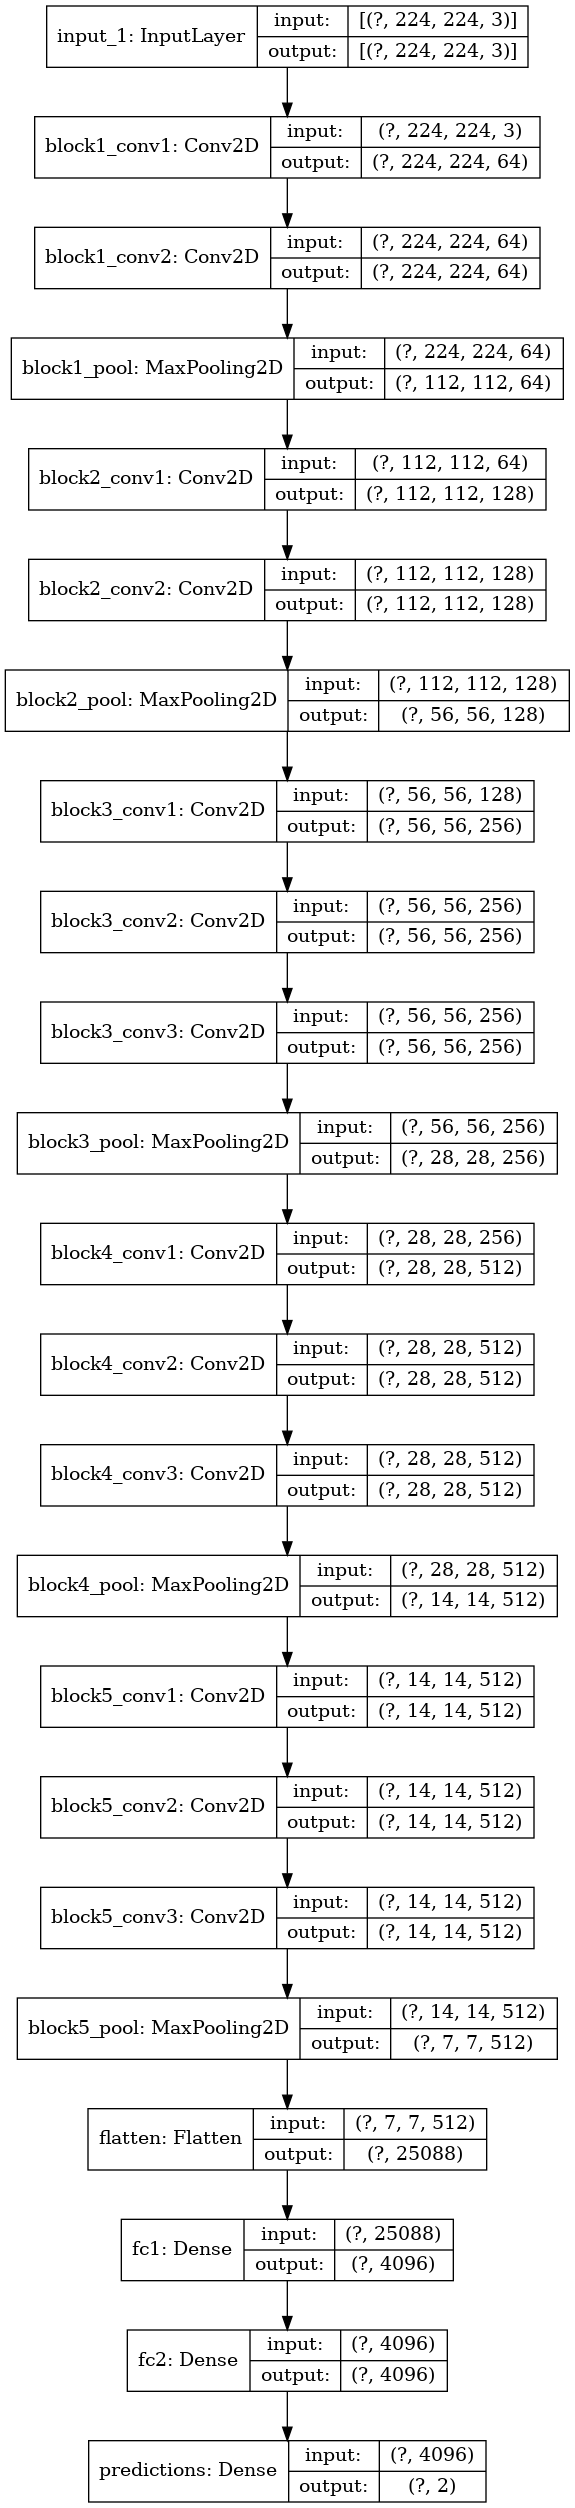

In [10]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

## Model Training MEMORIZING RANDOM

In [11]:
model.trainable= True
model.compile(optimizer=tf.keras.optimizers.Adagrad(), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
checkpoint = ModelCheckpoint(
    'basetuned_model.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)


csvlogger = CSVLogger(
    filename= "baseline_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='loss',
    factor=0.75,
    patience=3,
    verbose=1, 
    mode='auto'
)

class_weights = class_weight.compute_class_weight(
       'balanced',
        np.unique(train_generator.classes), 
        train_generator.classes)
class_weights = dict(enumerate(class_weights))

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

/home/maia/anaconda3/envs/MST_TRAIN/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [13]:
history = model.fit(
    train_generator,
    epochs = 200,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = test_generator,
    validation_steps = nb_test_samples//batch_size,
    verbose = 1,
    callbacks = callbacks,
    shuffle = True,
    class_weight=class_weights
)

Epoch 1/200
163/163 [==============================] - ETA: 0s - loss: 0.7132 - accuracy: 0.4989
Epoch 00001: loss improved from inf to 0.71325, saving model to basetuned_model.h5
163/163 [==============================] - 118s 726ms/step - loss: 0.7132 - accuracy: 0.4989 - val_loss: 0.6966 - val_accuracy: 0.4911 - lr: 0.0010
Epoch 2/200
163/163 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5064
Epoch 00002: loss improved from 0.71325 to 0.69325, saving model to basetuned_model.h5
163/163 [==============================] - 115s 704ms/step - loss: 0.6932 - accuracy: 0.5064 - val_loss: 0.6992 - val_accuracy: 0.5112 - lr: 0.0010
Epoch 3/200
163/163 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.5293
Epoch 00003: loss did not improve from 0.69325
163/163 [==============================] - 113s 696ms/step - loss: 0.6940 - accuracy: 0.5293 - val_loss: 0.6970 - val_accuracy: 0.4576 - lr: 0.0010
Epoch 4/200
163/163 [===========================

Epoch 27/200
163/163 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.5709
Epoch 00027: loss improved from 0.67786 to 0.67520, saving model to basetuned_model.h5
163/163 [==============================] - 113s 695ms/step - loss: 0.6752 - accuracy: 0.5709 - val_loss: 0.7223 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 28/200
163/163 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.5903
Epoch 00028: loss improved from 0.67520 to 0.67317, saving model to basetuned_model.h5
163/163 [==============================] - 117s 719ms/step - loss: 0.6732 - accuracy: 0.5903 - val_loss: 0.7245 - val_accuracy: 0.4911 - lr: 0.0010
Epoch 29/200
163/163 [==============================] - ETA: 0s - loss: 0.6697 - accuracy: 0.5957
Epoch 00029: loss improved from 0.67317 to 0.66968, saving model to basetuned_model.h5
163/163 [==============================] - 128s 783ms/step - loss: 0.6697 - accuracy: 0.5957 - val_loss: 0.7212 - val_accuracy: 0.4710 - lr: 0.0010
E

Epoch 52/200
163/163 [==============================] - ETA: 0s - loss: 0.3220 - accuracy: 0.8665
Epoch 00052: loss improved from 0.38731 to 0.32205, saving model to basetuned_model.h5
163/163 [==============================] - 107s 658ms/step - loss: 0.3220 - accuracy: 0.8665 - val_loss: 1.1104 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 53/200
163/163 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.8709
Epoch 00053: loss improved from 0.32205 to 0.30320, saving model to basetuned_model.h5
163/163 [==============================] - 108s 662ms/step - loss: 0.3032 - accuracy: 0.8709 - val_loss: 1.3948 - val_accuracy: 0.4308 - lr: 0.0010
Epoch 54/200
163/163 [==============================] - ETA: 0s - loss: 0.2763 - accuracy: 0.8940
Epoch 00054: loss improved from 0.30320 to 0.27630, saving model to basetuned_model.h5
163/163 [==============================] - 107s 659ms/step - loss: 0.2763 - accuracy: 0.8940 - val_loss: 1.1678 - val_accuracy: 0.4397 - lr: 0.0010
E

Epoch 78/200
163/163 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9987
Epoch 00078: loss did not improve from 0.00551
163/163 [==============================] - 105s 645ms/step - loss: 0.0073 - accuracy: 0.9987 - val_loss: 2.7436 - val_accuracy: 0.4844 - lr: 5.6250e-04
Epoch 79/200
163/163 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9990
Epoch 00079: loss did not improve from 0.00551

Epoch 00079: ReduceLROnPlateau reducing learning rate to 0.0004218749818392098.
163/163 [==============================] - 105s 643ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 3.2449 - val_accuracy: 0.4643 - lr: 5.6250e-04
Epoch 80/200
163/163 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9990
Epoch 00080: loss improved from 0.00551 to 0.00545, saving model to basetuned_model.h5
163/163 [==============================] - 107s 654ms/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 2.8653 - val_accuracy: 0.4688 - lr:

In [14]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

15/15 [==============================] - 5s 349ms/step - loss: 3.4197 - accuracy: 0.4712
Test Loss:  3.419743537902832
Test Accuracy:  0.4712153375148773


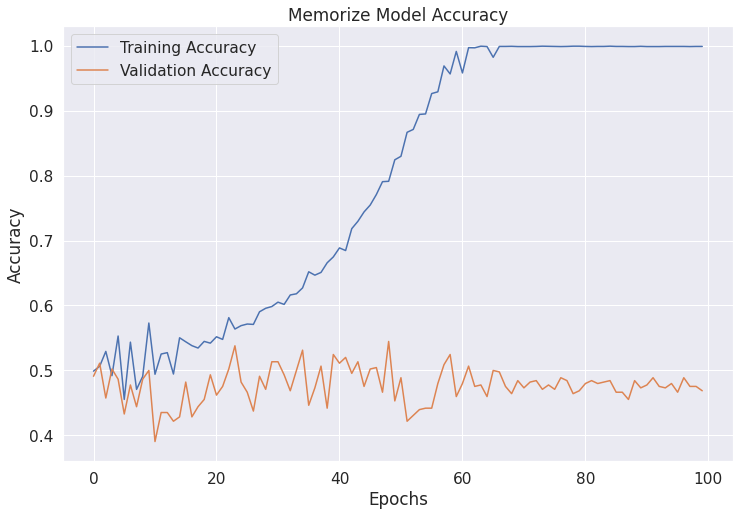

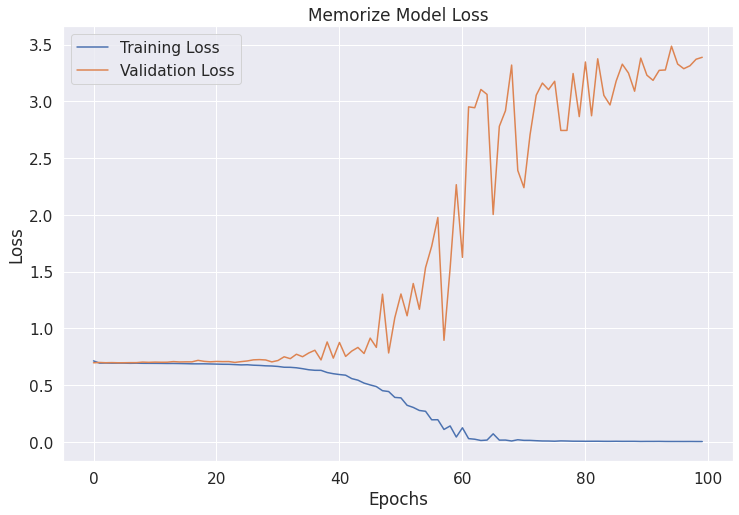

In [24]:
plt.subplot()
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.title('Memorize Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Memorize Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

/home/maia/anaconda3/envs/MST_TRAIN/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  if __name__ == '__main__':


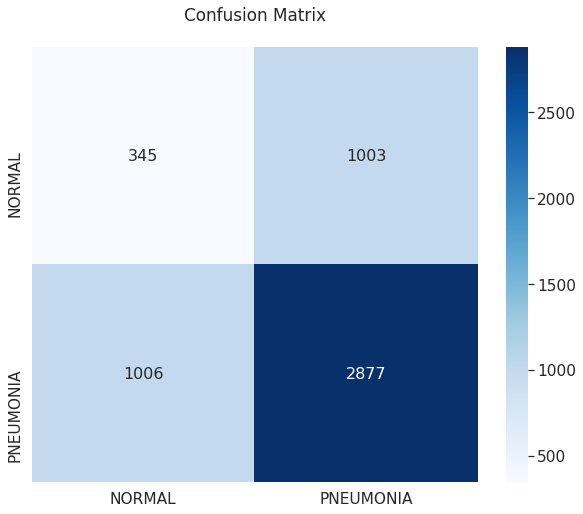

Classification Report

              precision    recall  f1-score   support

      NORMAL       0.26      0.26      0.26      1348
   PNEUMONIA       0.74      0.74      0.74      3883

    accuracy                           0.62      5231
   macro avg       0.50      0.50      0.50      5231
weighted avg       0.62      0.62      0.62      5231



In [28]:
Y_pred = model.predict(train_generator, nb_train_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(train_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(train_generator.class_indices.keys()), list(train_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues, fmt="d")
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix_train.png', transparent= False, bbox_inches= 'tight', dpi= 400)

plt.show()

print('Classification Report\n')
target_names = list(train_generator.class_indices.keys())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

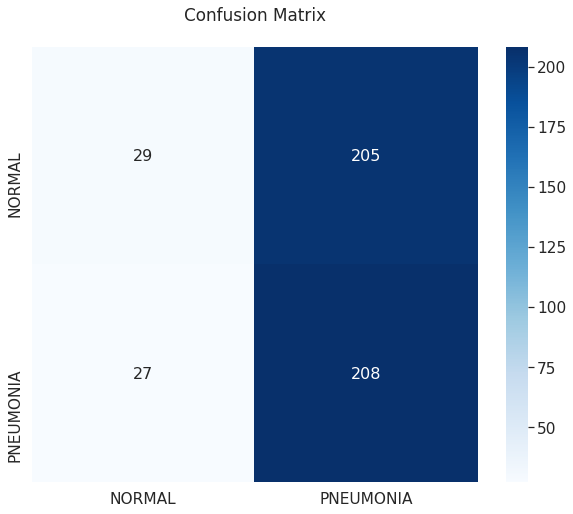

Classification Report

              precision    recall  f1-score   support

      NORMAL       0.52      0.12      0.20       234
   PNEUMONIA       0.50      0.89      0.64       235

    accuracy                           0.51       469
   macro avg       0.51      0.50      0.42       469
weighted avg       0.51      0.51      0.42       469



In [30]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues, fmt="d")
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight')
plt.show()

print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

from keras_lr_finder import LRFinder
lr_finder = LRFinder(model)
train_generator_lr = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= 3000,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 
X, Y = train_generator_lr.next()
lr_finder.find(X, Y, start_lr=0.001, end_lr=1, batch_size=32, epochs=20)